In [7]:
from datasets import load_dataset

dataset = load_dataset('eduvedras/VQG',split='train',trust_remote_code=True)

Generating train split: 15226 examples [14:15, 17.80 examples/s] 


In [29]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_id = 'openai/clip-vit-base-patch32'

model = CLIPModel.from_pretrained(model_id).to(device)
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)

In [30]:
prompt = "a correlation heatmap"

#tokenize the prompt
inputs = tokenizer(prompt, return_tensors="pt").to(device)
inputs

{'input_ids': tensor([[49406,   320, 29218, 12175,  3923, 49407]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [31]:
text_emb = model.get_text_features(**inputs)
text_emb.shape

torch.Size([1, 512])

/tmp/ipykernel_349/1959576737.py:7: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  plt.imshow(image.squeeze(0).T.cpu().numpy())
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


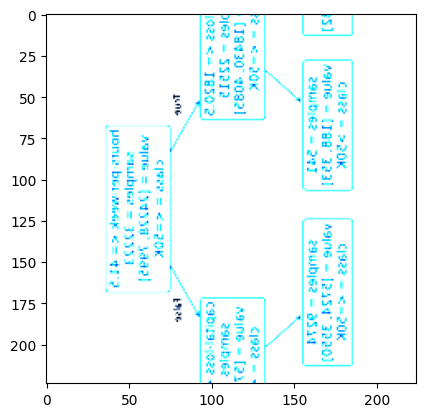

In [16]:
image = processor(text=None,images=dataset[0]['Chart'], return_tensors="pt")['pixel_values'].to(device)

import matplotlib.pyplot as plt

plt.imshow(image.squeeze(0).T.cpu().numpy())

In [18]:
image_emb = model.get_image_features(pixel_values=image)
image_emb.shape

import numpy as np

np.random.seed(0)
sample_idx = np.random.randint(0, len(dataset)+1, 100).tolist()
images = [dataset[idx] for idx in sample_idx]
len(images)

100

In [19]:
from tqdm.auto import tqdm

batch_size = 16
image_arr = None

for i in tqdm(range(0, len(images), batch_size)):
    batch = images[i:i+batch_size]
    batch_images = [image['Chart'] for image in batch]
    batch_images = processor(text=None,images=batch_images, return_tensors="pt",padding=True)['pixel_values'].to(device)
    batch_emb = model.get_image_features(pixel_values=batch_images)
    #convert to numpy array
    batch_emb = batch_emb.squeeze(0)
    batch_emb = batch_emb.cpu().detach().numpy()
    #add to larger array of all image embeddings
    if image_arr is None:
        image_arr = batch_emb
    else:
        image_arr = np.concatenate((image_arr, batch_emb), axis=0)

image_arr.shape

100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


(100, 512)

In [20]:
image_arr = image_arr.T / np.linalg.norm(image_arr, axis=1)

image_arr = image_arr.T

image_arr.min(), image_arr.max()

(-0.67692804, 0.1853973)

In [32]:
text_emb = text_emb.cpu().detach().numpy()

In [34]:
scores = np.dot(text_emb, image_arr.T)
scores.shape

(1, 100)

In [35]:
top_k = 5
idx = np.argsort(-scores[0])[:top_k]
idx

array([14, 65, 66, 21, 96])

In [36]:
for i in idx:
    print(scores[0][i])
    plt.imshow(images[i]['Chart'])
    plt.show()

2.93449


KeyError: 'image'